In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
X_sc = pd.read_csv('./X_scaled.csv')

In [9]:
## Setting Feature list for clustering
features = X_sc.columns.values 

## Clustering Hyper Parameter and Model Grid Search

### Setting parameters options

In [10]:
## Creating Dictionary for Hyper Parameters grid search in each model
model_dic = {"kmeans": {"init_seed": [10],
                  "inits"  :  ["k-means++","random"],
                  "clusters_list": range(2,20),
                  "tol": 0.0001},
             
            "hierarchy": {"linkage_method":['complete','ward', 'single',
                           'centroid','median','weighted'],"t": range(4,15),
                          "criterion": "maxclust"},
             
           "Agglomerative": {"linkage_method":['complete','ward', 'single',
                             'centroid','median','weighted'],'clusters_list':range(4,15),
                             "affinity": ['euclidean', 'l1', 'l2', 'manhattan',
                             'cosine', 'precomputed'],"clusters_list": range(4,10)},
             
            "dbscan": {"epslons":np.linspace(0.5,20,20),
                       "min_samples": [1,3,5,7,9,11,13,15,17,19,21,23,25,27,31]            
            }}

## Dictonary with features lists to grid search
df_dic = {'features': X_sc[features]}

### Function to Grid Search Models and Save Results in DataFrame

In [11]:
def grid_clusters(df_dic, par_dic):
    result_dic = {"Data_frame" :[],
                  "model": [],
                  "inertia": [],
                  "silhouette": [],
                  "Numb_clusters": [],
                  "Cluster_counts": [],
                  "model_params": []
                  }
    # loop dataFrames
    for df_name, df_data in df_dic.items():
        X = df_data
        # loop models
        for n_model in par_dic.keys():
            if n_model == "kmeans":
                # loop centroid seeds
                for n_init_seed in par_dic['kmeans']['init_seed']:
                    # loop Method for initialization
                    for n_init_method in par_dic['kmeans']['inits']:
                            # loop number of clusters
                            for n_cluster in par_dic['kmeans']['clusters_list']:
                                kmeans = KMeans(n_clusters=n_cluster,
                                                init=n_init_method,
                                                n_init=n_init_seed,
                                                tol=par_dic['kmeans']['tol'],
                                                random_state=42)
                                kmeans.fit(X)
                                #Saving results in dic
                                result_dic['Data_frame'].append(df_name)
                                result_dic['model'].append(n_model)
                                result_dic['inertia'].append(kmeans.inertia_)
                                result_dic['silhouette'].append(silhouette_score(X, kmeans.labels_))
                                result_dic['Numb_clusters'].append(n_cluster)
                                result_dic['Cluster_counts'].append(list(pd.Series(kmeans.labels_).value_counts()))
                                result_dic['model_params'].append("n_init_Seed: "
                                                                  + str(n_init_seed) +
                                                                  " n_init_met: " + 
                                                                  str(n_init_method)) 
                                
            if n_model == "hierarchy":
                # loop linkage_method
                for n_link_met in par_dic['hierarchy']['linkage_method']:
                    for n_clusters in par_dic['hierarchy']['t']:
                        z = hierarchy.linkage(X, method=n_link_met)
                        cls = hierarchy.fcluster(z, n_clusters, "maxclust")
                        # Saving results in dic
                        result_dic['Data_frame'].append(df_name)
                        result_dic['model'].append(n_model)
                        result_dic['inertia'].append(0)
                        result_dic['silhouette'].append(silhouette_score(X, cls))
                        result_dic['Numb_clusters'].append(n_clusters)
                        result_dic['Cluster_counts'].append(list(pd.Series(cls).value_counts()))
                        result_dic['model_params'].append(n_link_met)
                        
            if n_model == "Agglomerative":
                # loop linkage criterion
                for n_link_met in par_dic['Agglomerative']['linkage_method']:
                    #loop number of clusters
                    for n_clusters in par_dic['Agglomerative']['clusters_list']:
                        # loop method to compute linkage
                        for n_affinity in par_dic['Agglomerative']['affinity']:
                            ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
                            ac.fit(X)
                            # Saving results in dic
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, ac.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(ac.labels_).value_counts()))
                            result_dic['model_params'].append("Afin:" + n_affinity + ", Link:, " + n_link_met)
            
            if n_model == "dbscan":
                for e in par_dic['dbscan']['epslons']:
                    for samp in par_dic['dbscan']['min_samples']:
                        dbsc = DBSCAN(eps = e,
                                      min_samples = samp,
                                      metric='euclidean',
                                      leaf_size=30
                                      ).fit(X)
                        n_clusters = len(list(pd.Series(dbsc.labels_).value_counts()))
                        if n_clusters > 1 :      
                            result_dic['Data_frame'].append(df_name)
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(0)
                            result_dic['silhouette'].append(silhouette_score(X, dbsc.labels_))
                            result_dic['Numb_clusters'].append(n_clusters)
                            result_dic['Cluster_counts'].append(list(pd.Series(dbsc.labels_).value_counts()))
                            result_dic['model_params'].append("Epslon:" + str(round(e,2)) + ", min_samp: " + str(samp))                           
    return pd.DataFrame(result_dic)

In [12]:
## Runing grid search
results = grid_clusters(df_dic,model_dic)

## Printing parameters that had top silhouette score for each cluster algorithm

In [13]:
# Top agglomerative silhouette score
display(results[(results.model == 'Agglomerative')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top kmeans silhouette score
display(results[(results.model == 'kmeans')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top hierarchy silhouette score
display(results[(results.model == 'hierarchy')]\
.sort_values(by=['silhouette'],ascending = False).head(4))

# Top dbscan silhouette score
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 1)]\
.sort_values(by=['silhouette'],ascending = False).head(4))


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:precomputed, Link:, weighted"
137,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:precomputed, Link:, complete"
206,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:l2, Link:, single"
205,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:l1, Link:, single"


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,features,kmeans,51066.916867,0.337648,2,"[1033, 343]",n_init_Seed: 10 n_init_met: k-means++
18,features,kmeans,51066.916867,0.337648,2,"[1033, 343]",n_init_Seed: 10 n_init_met: random
15,features,kmeans,22289.779132,0.256127,17,"[346, 245, 178, 145, 111, 98, 43, 42, 32, 31, ...",n_init_Seed: 10 n_init_met: k-means++
11,features,kmeans,26762.830071,0.248160,13,"[488, 403, 118, 101, 78, 44, 35, 31, 27, 22, 1...",n_init_Seed: 10 n_init_met: k-means++


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
58,features,hierarchy,0.0,0.768383,4,"[1373, 1, 1, 1]",single
69,features,hierarchy,0.0,0.705863,4,"[1372, 2, 1, 1]",centroid
80,features,hierarchy,0.0,0.705863,4,"[1372, 2, 1, 1]",median
91,features,hierarchy,0.0,0.654997,4,"[1372, 2, 1, 1]",weighted


,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
609,features,dbscan,0.0,0.796648,2,"[1373, 3]","Epslon:20.0, min_samp: 31"
573,features,dbscan,0.0,0.796648,2,"[1373, 3]","Epslon:17.95, min_samp: 17"
556,features,dbscan,0.0,0.796648,2,"[1373, 3]","Epslon:16.92, min_samp: 13"
557,features,dbscan,0.0,0.796648,2,"[1373, 3]","Epslon:16.92, min_samp: 15"


## Chosing good models based on:
1. Silhuete score 
2. Inertia( for kmeans)
3. cluster count distributuion

## DBSCAN

In [18]:
display(results[(results.model == 'dbscan') &
               (results.Numb_clusters >= 3 )]\
.sort_values(by=['silhouette'],ascending = False)[56:69])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
359,features,dbscan,0.0,0.195415,12,"[788, 226, 82, 71, 69, 35, 33, 21, 17, 13, 11,...","Epslon:3.58, min_samp: 9"
360,features,dbscan,0.0,0.189717,11,"[788, 237, 82, 71, 69, 35, 33, 21, 17, 12, 11]","Epslon:3.58, min_samp: 11"
358,features,dbscan,0.0,0.187836,15,"[793, 199, 83, 71, 69, 35, 33, 21, 17, 13, 11,...","Epslon:3.58, min_samp: 7"
355,features,dbscan,0.0,0.182368,132,"[795, 83, 71, 69, 35, 33, 21, 17, 14, 11, 11, ...","Epslon:3.58, min_samp: 1"
384,features,dbscan,0.0,0.181159,5,"[803, 257, 246, 36, 34]","Epslon:4.61, min_samp: 31"
361,features,dbscan,0.0,0.176054,9,"[787, 261, 82, 71, 69, 35, 33, 21, 17]","Epslon:3.58, min_samp: 13"
362,features,dbscan,0.0,0.175833,9,"[786, 262, 82, 71, 69, 35, 33, 21, 17]","Epslon:3.58, min_samp: 15"
400,features,dbscan,0.0,0.175702,29,"[1269, 26, 19, 15, 8, 8, 3, 3, 3, 2, 2, 1, 1, ...","Epslon:6.66, min_samp: 1"
386,features,dbscan,0.0,0.169697,16,"[1192, 45, 30, 21, 19, 16, 13, 8, 7, 5, 5, 3, ...","Epslon:5.63, min_samp: 3"
363,features,dbscan,0.0,0.164144,8,"[785, 284, 78, 71, 69, 35, 33, 21]","Epslon:3.58, min_samp: 17"


In [20]:
## DBSCAN Parameters Chosen:
display(results.loc[[384]])
# saving parameters in instantiated model 
dbsc_1 = DBSCAN(eps = 4.61, min_samples = 31).fit(X_sc[features]).labels_
# dbsc_2 = DBSCAN(eps = 3.58, min_samples = 5).fit(X_sc).labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
384,features,dbscan,0.0,0.181159,5,"[803, 257, 246, 36, 34]","Epslon:4.61, min_samp: 31"


## Hierarchy

In [64]:
display(results[(results.model == 'hierarchy') &
               (results.Numb_clusters <10 )]\
.sort_values(by=['silhouette'],ascending = False)[30:80])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
52,features,hierarchy,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]",ward
49,features,hierarchy,0.0,0.211198,6,"[522, 411, 341, 64, 36, 2]",ward
51,features,hierarchy,0.0,0.210008,8,"[522, 411, 175, 144, 64, 36, 22, 2]",ward
48,features,hierarchy,0.0,0.203902,5,"[586, 411, 341, 36, 2]",ward
50,features,hierarchy,0.0,0.198196,7,"[522, 411, 197, 144, 64, 36, 2]",ward
47,features,hierarchy,0.0,0.182233,4,"[622, 411, 341, 2]",ward


In [67]:
## Hierarchy Parameters:
display(results.loc[[47]])
# saving labels 
z = hierarchy.linkage(X_sc[features], method="ward")
hierarchy_1 = hierarchy.fcluster(z, 4, "maxclust")
print("This model silhouette score: ",silhouette_score(X_sc[features], hierarchy_1))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
47,features,hierarchy,0.0,0.182233,4,"[622, 411, 341, 2]",ward


This model silhouette score:  0.18223295619879268


## Agglomerative

In [31]:
display(results[(results.model == 'Agglomerative')& (results.Numb_clusters <10)]\
.sort_values(by=['silhouette'],ascending = False)[0:10])

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:precomputed, Link:, weighted"
137,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:precomputed, Link:, complete"
206,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:l2, Link:, single"
205,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:l1, Link:, single"
204,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:euclidean, Link:, single"
168,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:euclidean, Link:, ward"
132,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:euclidean, Link:, complete"
133,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:l1, Link:, complete"
134,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:l2, Link:, complete"
135,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:manhattan, Link:, complete"


In [68]:
display(results.loc[[317]])
# Agglomerative parameters
ac = AgglomerativeClustering(n_clusters=9)
ac.fit(X_sc[features])
print("This model silhouette score: ",silhouette_score(X_sc[features],  ac.labels_))
agglomerative_1 = ac.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
317,features,Agglomerative,0.0,0.213238,9,"[522, 365, 175, 144, 64, 46, 36, 22, 2]","Afin:precomputed, Link:, weighted"


This model silhouette score:  0.21323821256955677


## Kmeans

In [19]:
display(results[(results.model == 'kmeans') & (results.Numb_clusters <10) ]\
.sort_values(by=['inertia'],ascending = True).sort_values(by=['silhouette'],ascending = False).\
        head(40))

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
0,features,kmeans,53747.464357,0.329951,2,"[1037, 343]",n_init_Seed: 10 n_init_met: k-means++
18,features,kmeans,53747.464357,0.329951,2,"[1037, 343]",n_init_Seed: 10 n_init_met: random
7,features,kmeans,34098.192596,0.242477,9,"[519, 439, 310, 42, 35, 22, 8, 3, 2]",n_init_Seed: 10 n_init_met: k-means++
25,features,kmeans,35174.989874,0.225263,9,"[538, 422, 165, 96, 51, 40, 39, 26, 3]",n_init_Seed: 10 n_init_met: random
24,features,kmeans,36810.350929,0.223911,8,"[538, 426, 179, 117, 51, 40, 26, 3]",n_init_Seed: 10 n_init_met: random
5,features,kmeans,38072.976259,0.219536,7,"[521, 426, 299, 54, 43, 35, 2]",n_init_Seed: 10 n_init_met: k-means++
4,features,kmeans,40523.102487,0.217403,6,"[560, 453, 327, 35, 3, 2]",n_init_Seed: 10 n_init_met: k-means++
22,features,kmeans,41323.581853,0.217263,6,"[538, 485, 288, 40, 26, 3]",n_init_Seed: 10 n_init_met: random
6,features,kmeans,35693.246235,0.216597,8,"[517, 426, 201, 152, 44, 35, 3, 2]",n_init_Seed: 10 n_init_met: k-means++
3,features,kmeans,42942.765100,0.211827,5,"[561, 453, 329, 35, 2]",n_init_Seed: 10 n_init_met: k-means++


In [69]:
# Kmeans parameters
display(results.loc[[21]])
kmeans_1 = KMeans(n_clusters=5, init='random',random_state=42).fit(X_sc[features])
print("This model silhouette score: ",silhouette_score(X_sc[features],  kmeans_1.labels_))
kmeans_1 = kmeans_1.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
21,features,kmeans,40172.799907,0.224799,5,"[536, 448, 331, 35, 26]",n_init_Seed: 10 n_init_met: random


This model silhouette score:  0.22479898567697087


In [97]:
# Kmeans parameters
display(results.loc[[7]])
kmeans_2 = KMeans(n_clusters=9, init='k-means++',
                random_state=42).fit(X_sc[features])
print("This model silhouette score: ",silhouette_score(X_sc[features],  kmeans_2.labels_))
kmeans_2 = kmeans_2.labels_

,Data_frame,model,inertia,silhouette,Numb_clusters,Cluster_counts,model_params
7,features,kmeans,31896.397967,0.240412,9,"[479, 422, 247, 85, 44, 40, 35, 22, 2]",n_init_Seed: 10 n_init_met: k-means++


This model silhouette score:  0.24041237210177002


In [54]:
# raw_df.groupby(['dbscan_s9_e_4.5'])[["Return_6m",'Return_12m','Return_24m']].agg([np.median])

In [55]:
## Checking number of Cluster using the elbow method

## Analizing Elbow method with KMeans

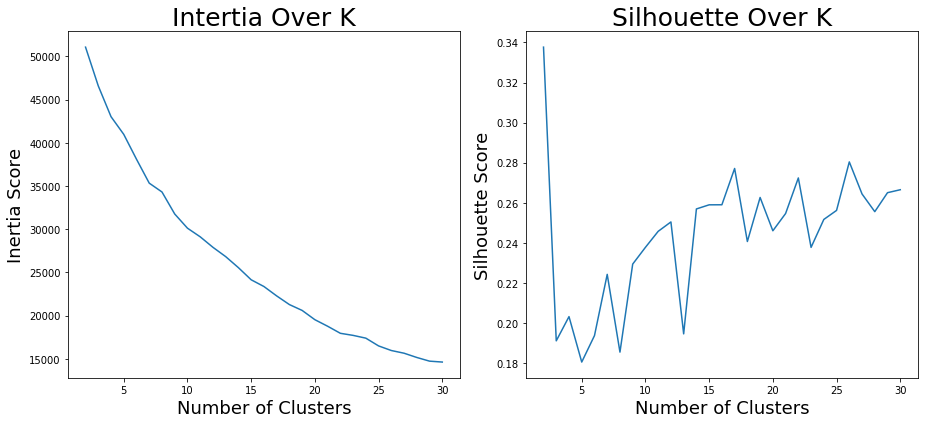

In [47]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value,)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(X_sc[features])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 6))
eval_scores["inertia"].plot(ax=ax[0], title="Intertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
# ax[0].annotate('Elbow @ K=4', xy = (0.10, .46),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.45), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
# ax[1].annotate('Elbow @ K=4', xy = (0.13, .56),  xycoords = 'axes fraction', \
#     xytext = (0.24, 0.65), fontsize = 14, \
#     color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))
ax[0].set_title('Intertia Over K',fontsize = 25)
ax[1].set_title('Silhouette Over K',fontsize = 25)
ax[0].set_xlabel('Number of Clusters', size = 18)
ax[1].set_xlabel('Number of Clusters', size = 18)
ax[0].set_ylabel('Inertia Score', size = 18)
ax[1].set_ylabel('Silhouette Score', size = 18)

fig.tight_layout()

## Adding clusters classifications to DF



In [98]:
raw_df = pd.read_csv('./clean_df.csv')

raw_df['dbsc_1'] = dbsc_1
raw_df['agglomerative_1'] = agglomerative_1
raw_df['hierarchy_1'] = hierarchy_1
raw_df['kmeans_1'] = kmeans_1
raw_df['kmeans_2'] = kmeans_2

raw_df.to_csv('./raw_df_with_cluster.csv',index=False)

In [149]:
def get_rf_coef(X,Y_list):
    coef_df = pd.DataFrame()
    coef_df['coef_name'] = X.columns.values
    
    for y in Y_list:
        my_params = {'criterion': ['gini', 'entropy'],
                            'n_estimators' : [3,4,5,10,20],
        #                    'max_depth': ['10, 15, 20']
                            'max_features' : ['auto' , 1.0,0.5,0.75]
                            }
        gs = GridSearchCV(RandomForestClassifier(random_state=42),my_params,cv=5)
        gs.fit(X,y)  
        rf = RandomForestClassifier(random_state=42,
                                    criterion=gs.best_params_['criterion'],
                                    max_features=gs.best_params_['max_features'],
                                    n_estimators = gs.best_params_['n_estimators'])
        
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
        rf.fit(X_train,y_train)
        importances = rf.feature_importances_
        coef_df[y.name] = importances
        print(y.name, round(gs.best_score_,3)
              ,round(rf.score(X_train,y_train),3)
              ,round(rf.score(X_test,y_test),3))
#       print(gs.best_params_)      
    return coef_df
# print(gs.score(X_test,y_test))
# predictions = gs.predict(test[features])

In [150]:
coef_df = get_rf_coef(raw_df[features],[raw_df['dbsc_1'],
            raw_df['agglomerative_1'], raw_df['hierarchy_1'],
            raw_df['kmeans_1'], raw_df['kmeans_2']])

dbsc_1 0.95 0.998 0.959


C:\Users\berku\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


agglomerative_1 0.965 0.998 0.959


C:\Users\berku\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


hierarchy_1 0.984 0.999 0.98
kmeans_1 0.982 0.999 0.977


C:\Users\berku\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


kmeans_2 0.971 0.994 0.971


In [151]:
coef_df.head()

,coef_name,dbsc_1,agglomerative_1,hierarchy_1,kmeans_1,kmeans_2
0,Management Fee,0.005582,0.001666,0.006129,0.004595,0.002943
1,Minimum Investment,0.017842,0.006156,0.002156,0.002425,0.001813
2,Performance Fee,0.005064,0.011660,0.000454,0.002152,0.003698
3,Liquidity Ratios,0.013999,0.015443,0.008178,0.006037,0.019388
4,age_months,0.003538,0.001919,0.002180,0.001460,0.001451


In [152]:
l1=[]
l2=[]
for col in coef_df.columns:
    if col != 'coef_name':
        l1.extend(coef_df.sort_values([col],
                                      ascending=False)['coef_name'].head(10).values)
        l2.extend([col for i in range(10)])

In [153]:
top_coefs = pd.DataFrame(columns = ['coef_name','model'])
top_coefs['coef_name'] = l1
top_coefs['model'] = l2
top_coefs['coef_name'].value_counts()

CVM Category_Equities                                    5
Volatility_6m                                            5
CVM Category_Fixed Income                                4
CVM Category_Multimarket                                 4
Tax Classification_Long Term                             3
Performance Fee Reference Index_Other_performance_fee    3
Volatility_24m                                           2
Excess_Return_-_Dollar_6m                                2
Average_Assets_12m                                       2
Leveraged Anbima_Yes                                     2
Volatility_12m                                           2
Private Credit Anbima_Yes                                2
Benchmark_IBX                                            1
Excess_Return_-_Ibovespa_12m                             1
Average_Assets_24m                                       1
Benchmark_Other_Benchmark                                1
Excess_Return_-_Dollar_12m                              

In [155]:
coef_df.head(1)

,coef_name,dbsc_1,agglomerative_1,hierarchy_1,kmeans_1,kmeans_2
0,Management Fee,0.005582,0.001666,0.006129,0.004595,0.002943


## DBSCAN best param random forest:

In [163]:
coef_df.sort_values(['dbsc_1'],ascending=False)[['coef_name','dbsc_1']].head(10)

,coef_name,dbsc_1
10,Tax Classification_Long Term,0.146085
7,CVM Category_Equities,0.133016
24,Benchmark_Other_Benchmark,0.094504
37,Volatility_24m,0.082779
36,Volatility_12m,0.075121
17,Performance Fee Reference Index_Other_performa...,0.043112
20,Benchmark_IBX,0.034542
11,Tax Classification_Short Term,0.030589
35,Volatility_6m,0.029205
39,Excess_Return_-_CDI_Opening_12m,0.025207


## Agglomerative best param:

In [162]:
coef_df.sort_values(['agglomerative_1'],
                    ascending=False)[['coef_name','agglomerative_1']].head(10)

,coef_name,agglomerative_1
5,CVM Category_Fixed Income,0.227410
6,CVM Category_Multimarket,0.205150
16,Performance Fee Reference Index_100% do Ibovespa,0.072898
17,Performance Fee Reference Index_Other_performa...,0.046952
35,Volatility_6m,0.041435
13,Private Credit Anbima_Yes,0.038214
31,Average_Assets_24m,0.037143
30,Average_Assets_12m,0.036972
7,CVM Category_Equities,0.035097
18,Performance Fee Reference Index_There is not,0.026567


## Hierarchy 

In [161]:
coef_df.sort_values(['hierarchy_1'],ascending=False)[['coef_name','hierarchy_1']].head(10)

,coef_name,hierarchy_1
5,CVM Category_Fixed Income,0.257268
6,CVM Category_Multimarket,0.195283
7,CVM Category_Equities,0.178616
35,Volatility_6m,0.082749
37,Volatility_24m,0.069640
10,Tax Classification_Long Term,0.035931
44,Excess_Return_-_Dollar_6m,0.033874
13,Private Credit Anbima_Yes,0.028630
17,Performance Fee Reference Index_Other_performa...,0.028414
8,CVM Category_FX,0.011618


## K means 1 (k=5)

In [159]:
coef_df.sort_values(['kmeans_1'],ascending=False)[['coef_name','kmeans_1']].head(10)

,coef_name,kmeans_1
5,CVM Category_Fixed Income,0.295584
6,CVM Category_Multimarket,0.156660
38,Excess_Return_-_CDI_Opening_6m,0.105968
44,Excess_Return_-_Dollar_6m,0.072123
41,Excess_Return_-_Ibovespa_6m,0.056325
36,Volatility_12m,0.041468
7,CVM Category_Equities,0.039111
35,Volatility_6m,0.037999
25,Last_Assets,0.031858
14,Leveraged Anbima_Yes,0.025615


## K means 1 (k=9)

In [160]:
coef_df.sort_values(['kmeans_2'],ascending=False)[['coef_name','kmeans_2']].head(10)

,coef_name,kmeans_2
6,CVM Category_Multimarket,0.275451
5,CVM Category_Fixed Income,0.157721
10,Tax Classification_Long Term,0.069470
35,Volatility_6m,0.065285
7,CVM Category_Equities,0.047024
14,Leveraged Anbima_Yes,0.040959
42,Excess_Return_-_Ibovespa_12m,0.031221
45,Excess_Return_-_Dollar_12m,0.029856
30,Average_Assets_12m,0.028708
15,Performance Fee Reference Index_100% do IBX,0.027341


In [ ]:
tsne

## Analizing top 10 most important Features for K-means k=5

In [168]:
# Kmeans k=5 group by
top10_kmeans_coef = list(coef_df.sort_values(['kmeans_1'],ascending=False)['coef_name'].head(10).values)
raw_df.groupby(['kmeans_1'])[top10_kmeans_coef].agg([np.mean,len])

CVM Category_Fixed Income      CVM Category_Multimarket       \
                              mean  len                     mean  len   
kmeans_1                                                                
0                         0.015625  448                 0.917411  448   
1                         1.000000   26                 0.000000   26   
2                         0.994403  536                 0.005597  536   
3                         0.000000  331                 0.036254  331   
4                         0.028571   35                 0.000000   35   

         Excess_Return_-_CDI_Opening_6m        Excess_Return_-_Dollar_6m  \
                                   mean    len                      mean   
kmeans_1                                                                   
0                              0.007826  448.0                  0.066744   
1                             -0.002889   26.0                  0.056030   
2                              0.007292  536.0                  0.066210   
3                              0.223999  331.0                  0.282918   
4                             -0.049240   35.0                  0.009678   

                Excess_Return_-_Ibovespa_6m        Volatility_12m         \
            len                        mean    len           mean    len   
kmeans_1                                                                   
0         448.0                   -0.190088  448.0       0.063241  448.0   
1          26.0                   -0.200803   26.0       0.000546   26.0   
2         536.0                   -0.190622  536.0       0.007792  536.0   
3         331.0                    0.026085  331.0       0.215505  331.0   
4          35.0                   -0.247155   35.0       0.147069   35.0   

         CVM Category_Equities      Volatility_6m          Last_Assets         \
                          mean  len          mean    len          mean    len   
kmeans_1                                                                        
0                     0.066964  448      0.064775  448.0  2.753336e+08  448.0   
1                     0.000000   26      0.000478   26.0  1.504803e+10   26.0   
2                     0.000000  536      0.007676  536.0  8.142899e+08  536.0   
3                     0.957704  331      0.223864  331.0  1.375748e+08  331.0   
4                     0.000000   35      0.147818   35.0  1.108542e+08   35.0   

         Leveraged Anbima_Yes       
                         mean  len  
kmeans_1                            
0                    0.700893  448  
1                    0.000000   26  
2                    0.029851  536  
3                    0.199396  331  
4                    0.000000   35

## Generating 3D Plots with different feature combination

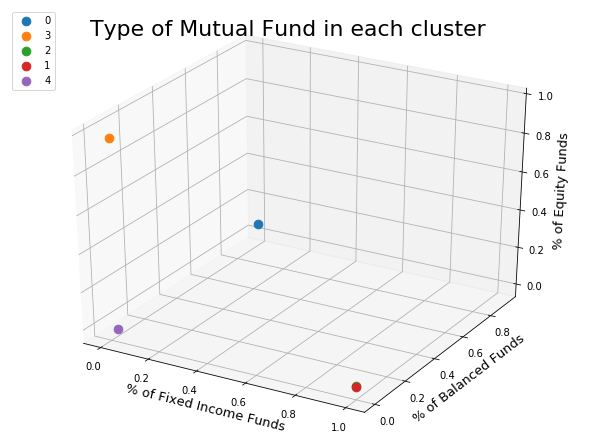

In [327]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)

for i in raw_df['kmeans_1'].unique():
    xs = raw_df[raw_df['kmeans_1']==i]['CVM Category_Fixed Income'].mean()
    ys = raw_df[raw_df['kmeans_1']==i]['CVM Category_Multimarket'].mean()
    zs = raw_df[raw_df['kmeans_1']==i]['CVM Category_Equities'].mean()
    ax.scatter(xs, ys, zs, label=str(i),s=75)

    
ax.set_title('Type of Mutual Fund in each cluster  ',loc='center', fontsize=22)
ax.set_xlabel('% of Fixed Income Funds', fontsize=13)
ax.set_ylabel('% of Balanced Funds', fontsize=13)
ax.set_zlabel('% of Equity Funds', fontsize=13)
ax.legend(loc = 2)
plt.show()

In [218]:
raw_df.groupby(['kmeans_1'])[['CVM Category_Fixed Income',
                              'CVM Category_Multimarket',
                              'CVM Category_Equities'
                             ]].agg([np.mean])

,CVM Category_Fixed Income,CVM Category_Multimarket,CVM Category_Equities
,mean,mean,mean
kmeans_1,,,
0,0.015625,0.917411,0.066964
1,1.000000,0.000000,0.000000
2,0.994403,0.005597,0.000000
3,0.000000,0.036254,0.957704
4,0.028571,0.000000,0.000000


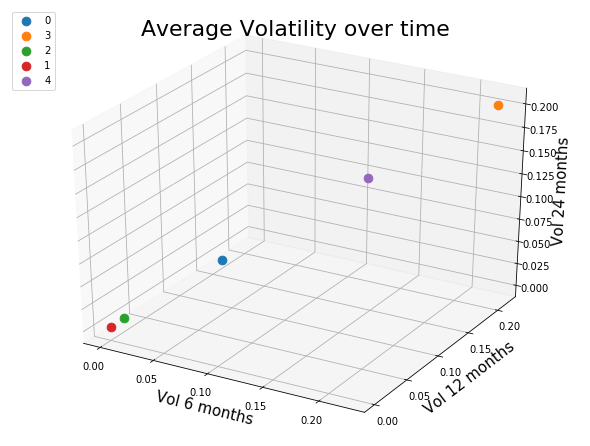

In [372]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)

for i in raw_df['kmeans_1'].unique():
    xs = np.average(raw_df[raw_df['kmeans_1']==i]['Volatility_6m'])
    ys = np.average(raw_df[raw_df['kmeans_1']==i]['Volatility_12m'])
    zs = np.average(raw_df[raw_df['kmeans_1']==i]['Volatility_24m'])
    ax.scatter(xs, ys, zs, label=str(i),s=75)
    
ax.set_title('Average Volatility over time',loc='center', fontsize=22)
ax.set_xlabel('Vol 6 months', fontsize=15)
ax.set_ylabel('Vol 12 months', fontsize=15)
ax.set_zlabel('Vol 24 months', fontsize=15)
ax.legend(loc = 2)
plt.show()

In [328]:
raw_df[raw_df['kmeans_1']==1]['Volatility_6m'].values

array([4.78762033e-04, 1.26607670e-05, 1.12552208e-03, 1.44112477e-04,
       2.03820157e-04, 2.01645201e-04, 1.07496206e-04, 1.12589191e-03,
       4.78793589e-04, 9.61367400e-05, 2.82210029e-04, 7.50962222e-04,
       3.04062980e-05, 3.12534290e-05, 2.32871452e-04, 6.55547750e-05,
       5.99265100e-06, 3.06199570e-05, 1.64600810e-05, 5.87674706e-03,
       1.36122120e-04, 1.36063206e-04, 2.40676464e-04, 1.36109402e-04,
       2.42605532e-04, 2.41686391e-04])

In [345]:
raw_df.groupby(['kmeans_1'])[['Volatility_24m'
#                               ,'Volatility_12m'
#                               ,'Volatility_24m'
                             ]].agg([np.mean,np.max,min,len])

Volatility_24m                           
                   mean      amax       min    len
kmeans_1                                          
0              0.063065  0.809055  0.001292  448.0
1              0.001608  0.007780  0.001231   26.0
2              0.010340  0.114209  0.000927  536.0
3              0.201937  0.445088  0.060240  331.0
4              0.135187  0.139129  0.114126   35.0

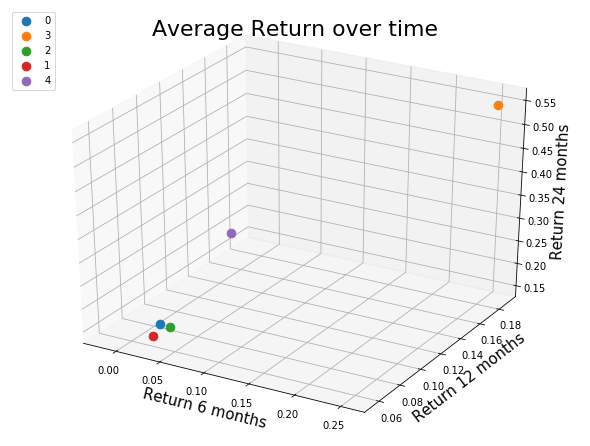

In [374]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)

for i in raw_df['kmeans_1'].unique():
    xs =  np.average(raw_df[raw_df['kmeans_1']==i]['Return_6m'])
    ys = np.average(raw_df[raw_df['kmeans_1']==i]['Return_12m'])
    zs = np.average(raw_df[raw_df['kmeans_1']==i]['Return_24m'])
    ax.scatter(xs, ys, zs, label=str(i),s=75)

    
ax.set_title('Average Return over time',loc='center', fontsize=22)
ax.set_xlabel('Return 6 months', fontsize=15)
ax.set_ylabel('Return 12 months', fontsize=15)
ax.set_zlabel('Return 24 months', fontsize=15)
ax.legend(loc = 2)
plt.show()

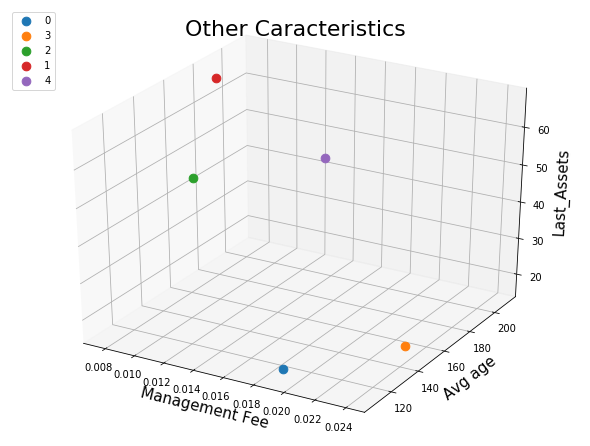

In [376]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)

for i in raw_df['kmeans_1'].unique():
    xs = np.average(raw_df[raw_df['kmeans_1']==i]['Management Fee']) #Last_Assets
    ys = np.average(raw_df[raw_df['kmeans_1']==i]['age_months'])
    zs = np.average(raw_df[raw_df['kmeans_1']==i]['#_Funds_managed'])
    ax.scatter(xs, ys, zs, label=str(i),s=75)

    
ax.set_title('Other Caracteristics',loc='center', fontsize=22)
ax.set_xlabel('Management Fee', fontsize=15)
ax.set_ylabel('Avg age', fontsize=15)
ax.set_zlabel('Last_Assets', fontsize=15)
ax.legend(loc = 2)
plt.show()

In [231]:
raw_df.groupby(['kmeans_1'])[['Last_Assets',
                              'age_months',
                              '#_Funds_managed'
                              ,'Management Fee'
                             ]].agg([np.average])

,Last_Assets,age_months,#_Funds_managed,Management Fee
,average,average,average,average
kmeans_1,,,,
0,2.753336e+08,108.100446,17.214286,0.019268
1,1.504803e+10,183.423077,66.576923,0.007673
2,8.142899e+08,148.250000,49.423507,0.009522
3,1.375748e+08,143.353474,18.416918,0.023995
4,1.108542e+08,209.714286,43.257143,0.012657


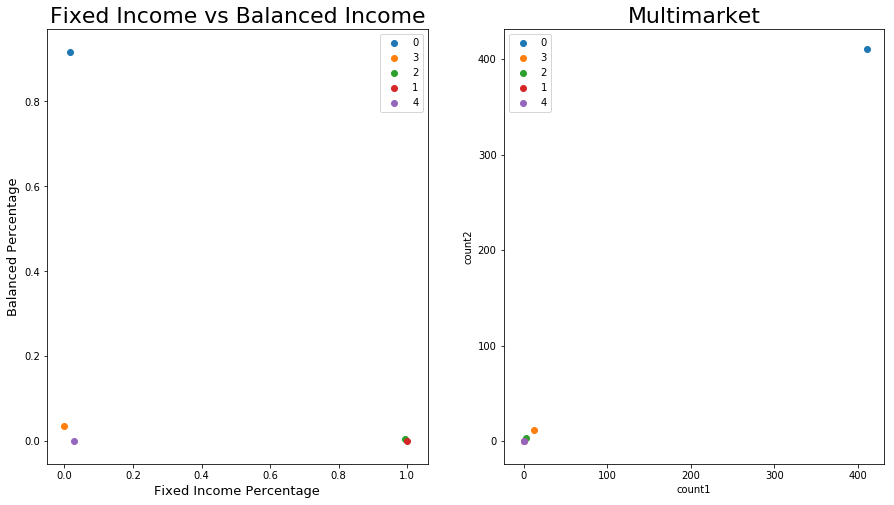

In [192]:
fig, ax = plt.subplots(1,2,figsize=(15,8),sharey=False)
ax = ax.ravel()
for i in raw_df['kmeans_1'].unique():
    ax[0].scatter(raw_df[raw_df['kmeans_1']==i]['CVM Category_Fixed Income'].mean()
                  ,raw_df[raw_df['kmeans_1']==i]['CVM Category_Multimarket'].mean()
                  , label=str(i))
    ax[1].scatter(raw_df[raw_df['kmeans_1']==i]['CVM Category_Multimarket'].sum()
                  ,raw_df[raw_df['kmeans_1']==i]['CVM Category_Multimarket'].sum()
                  , label=str(i))
    
ax[0].set_title('Fixed Income vs Balanced Income', fontsize=22)
ax[0].set_xlabel('Fixed Income Percentage', fontsize=13)
ax[0].set_ylabel('Balanced Percentage', fontsize=13)
ax[0].legend()

ax[1].set_title('Multimarket', fontsize=22)
ax[1].set_xlabel('count1')
ax[1].set_ylabel('count2')
ax[1].legend()

In [237]:
len([3.1,3.2,3.3,5.9,5.10,6.1,1.1,1.2,1.3,7.9,7.10,8.1])

12

In [270]:
ex= pd.DataFrame()
ex['label'] =[0,0,0,1,1,1,2,2,2,3,3,3]
ex['return'] = [0.1,.01,.35,.9,.95,1.1,0.1,.2,.3,.9,.99,1.1]
ex['volatility'] =[5.1,5.9,6.3,3.9,3.10,4.1,1.1,1.2,1.3,7.9,7.10,8.1]

In [271]:
ex[ex['label']==i]['return'].values

array([0.9 , 0.99, 1.1 ])

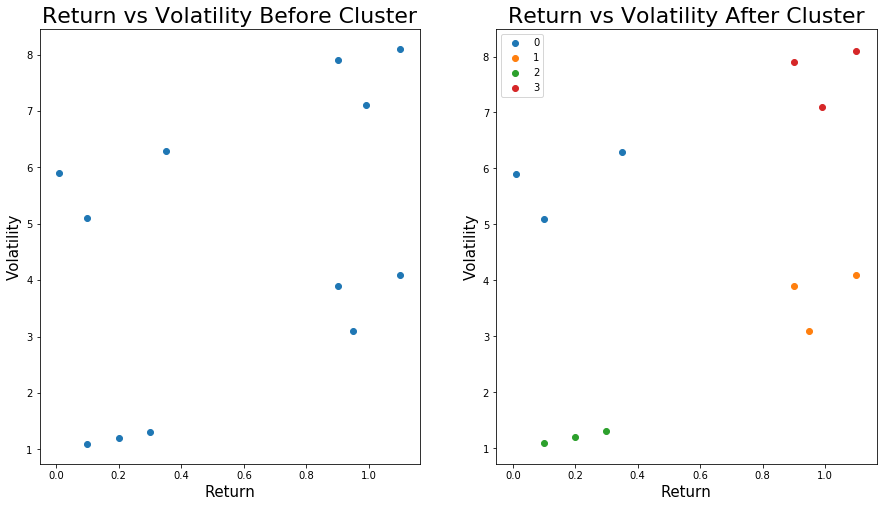

In [277]:
fig, ax = plt.subplots(1,2,figsize=(15,8),sharey=False)
ax = ax.ravel()

ax[0].scatter(ex['return'].values
                 ,ex['volatility'].values
                 )

for i in ex['label'].unique():  
    ax[1].scatter(ex[ex['label']==i]['return'].values
                 ,ex[ex['label']==i]['volatility'].values
                 , label=str(i))

    
ax[0].set_title('Return vs Volatility Before Cluster', fontsize=22)
ax[0].set_xlabel('Return', fontsize=15)
ax[0].set_ylabel('Volatility', fontsize=15)


ax[1].set_title('Return vs Volatility After Cluster', fontsize=22)
ax[1].set_xlabel('Return', fontsize=15)
ax[1].set_ylabel('Volatility', fontsize=15)
ax[1].legend()

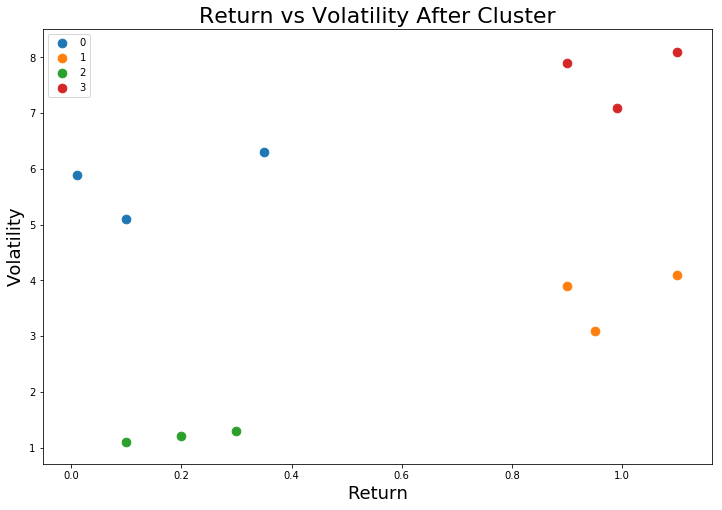

In [302]:
plt.figure(figsize=(12, 8))

for i in ex['label'].unique():  
    plt.scatter(ex[ex['label']==i]['return'].values
                 ,ex[ex['label']==i]['volatility'].values
                 , label=str(i),s = 75)
plt.title('Return vs Volatility After Cluster', fontsize=22)
plt.xlabel('Return', fontsize=18)
plt.ylabel('Volatility', fontsize=18)
plt.legend();

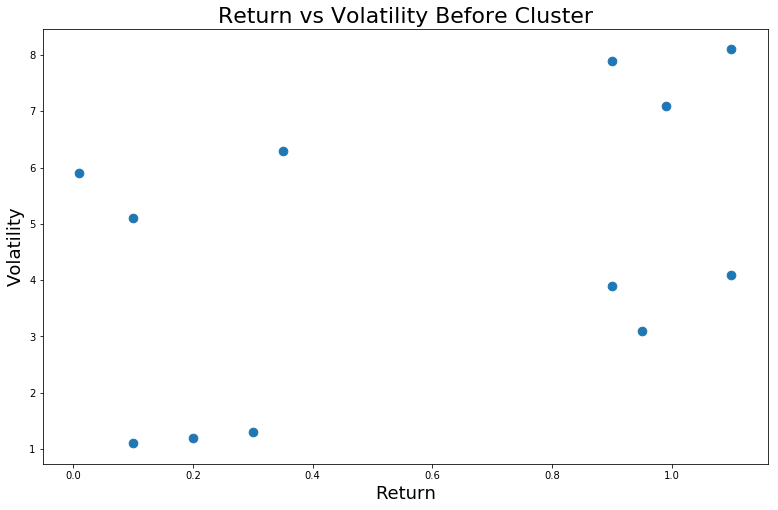

In [303]:
plt.figure(figsize=(13, 8))
plt.scatter(ex['return'].values
                 ,ex['volatility'].values, s = 75)
plt.title('Return vs Volatility Before Cluster', fontsize=22)
plt.xlabel('Return', fontsize=18)
plt.ylabel('Volatility', fontsize=18);

AttributeError: 'AxesSubplot' object has no attribute 'ravel'

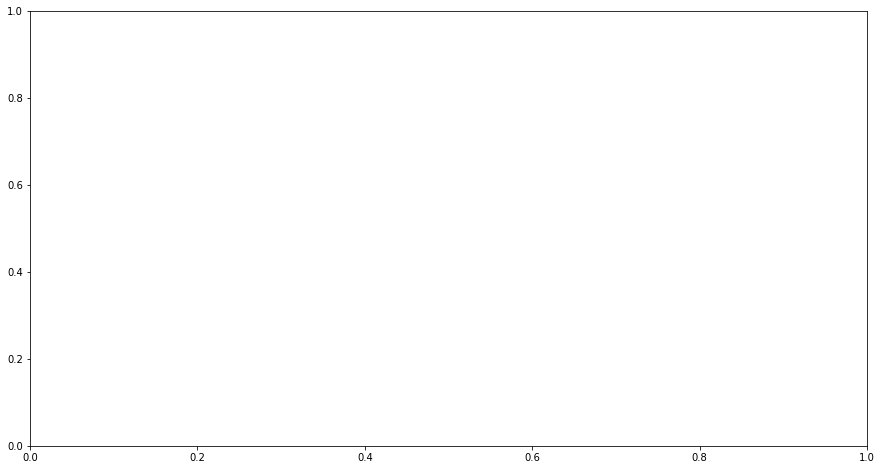

In [282]:
fig, ax = plt.subplots(1,1,figsize=(15,8),sharey=False)
ax = ax.ravel()

ax[0].scatter(ex['return'].values
                 ,ex['volatility'].values
                 )


ax[0].set_title('Return vs Volatility Before Cluster', fontsize=22)
ax[0].set_xlabel('Return', fontsize=15)
ax[0].set_ylabel('Volatility', fontsize=15)



In [371]:
raw_df.groupby(['kmeans_1'])\
                [["CVM Category_Fixed Income",'CVM Category_Multimarket'
                  ,'Volatility_24m','Volatility_6m','Tax Classification_Long Term',
                  'Volatility_12m','Private Credit Anbima_Yes',
                 'Performance Fee Reference Index_There is not','Liquidity Ratios',
                 'Performance Fee',
                  'age_months'
                 ]].agg([np.mean])

,CVM Category_Fixed Income,CVM Category_Multimarket,Volatility_24m,Volatility_6m,Tax Classification_Long Term,Volatility_12m,Private Credit Anbima_Yes,Performance Fee Reference Index_There is not,Liquidity Ratios,Performance Fee,age_months
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
kmeans_1,,,,,,,,,,,
0,0.015625,0.917411,0.063065,0.064775,0.890625,0.063241,0.084821,0.383929,10.399554,0.119933,108.100446
1,1.000000,0.000000,0.001608,0.000478,0.846154,0.000546,0.153846,0.961538,0.192308,0.007692,183.423077
2,0.994403,0.005597,0.010340,0.007676,0.917910,0.007792,0.208955,0.929104,4.891791,0.013993,148.250000
3,0.000000,0.036254,0.201937,0.223864,0.018127,0.215505,0.003021,0.555891,10.132931,0.087190,143.353474
4,0.028571,0.000000,0.135187,0.147818,0.857143,0.147069,0.057143,1.000000,0.800000,0.000000,209.714286


In [375]:
raw_df.columns

Index(['Name', 'CNPJ', 'Management Fee', 'Minimum Investment',
       'Performance Fee', 'Portfolio Manager', 'Liquidity Ratios',
       'age_months', 'CVM Category_Fixed Income', 'CVM Category_Multimarket',
       'CVM Category_Equities', 'CVM Category_FX', 'Tax Classification_Exempt',
       'Tax Classification_Long Term', 'Tax Classification_Short Term',
       'Private Credit Anbima_Not applicable', 'Private Credit Anbima_Yes',
       'Leveraged Anbima_Yes', 'Performance Fee Reference Index_100% do IBX',
       'Performance Fee Reference Index_100% do Ibovespa',
       'Performance Fee Reference Index_Other_performance_fee',
       'Performance Fee Reference Index_There is not', 'Benchmark_Dollar',
       'Benchmark_IBX', 'Benchmark_IMA-B', 'Benchmark_Ibovespa',
       'Benchmark_Not Informed', 'Benchmark_Other_Benchmark', 'Last_Assets',
       'Last_Assets_date', 'Assets_Flow_6m', 'Assets_Flow_12m',
       'Assets_Flow_24m', 'Average_Assets_6m', 'Average_Assets_12m',
       'Avera

7